# Introduction
This notebook is testing how μMerge handles ChIP-seq replicates in comparison to bedtools merge and bedtools intersect.


# Raw Reads Processing Pipeline

## Peak calling with MACS

- Raw ChIP-seq files were processed using the Dowell Labs ChIP-seq Nextflow pipeline (https://github.com/Dowell-Lab/ChIP-Flow).

- Peak calling with Macs2 was run on mapped reads

```sh
macs2 callpeak \
 -c $BAM_DIR/${CTRL1}.sorted.bam \
 -t $BAM_DIR/${TREATMENT1}.sorted.bam \
 --outdir $OUT \
 -n ${ID_1} \
 -g hs \
 -f BAM \
 -q 0.001
 
``` 

## Motif scanning with FIMO

- Transcription Motifs were scanned for based summit locations for each peak call

```sh
fimo -max-stored-scores 1000000 --thresh 1e-4 -oc ${outdir}/${bed} -motif $motiffile ${hocomoco}/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme ${chip_fa}/${bed}_mac\
s.fa
```

## Merging Regions

- bedtools merge

- bedtools intersect

- muMerge 

# Load libraries

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('/Users/rusi2317/projects/mumerge_test/bin/mumerge_explore'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
pkg_dir='/Users/rusi2317/.local/lib/python3.6/site-packages/'
sys.path.append(os.path.abspath(pkg_dir))

In [3]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import entropy
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
from mumerge_explore.load_data import *
from mumerge_explore.plot_figures import *
from mumerge_explore.process_regions import *

## Filter regions for merging and get distances between centers-motif

In [5]:
##individual samples
andrysik_samples = ['HCT116_DMSO_TP53','HCT116_Nutlin_TP53',
                    'MCF7_DMSO_TP53','MCF7_Nutlin_TP53',
                   'SJSA_DMSO_TP53', 'SJSA_Nutlin_TP53']

sample_chip = '/Users/rusi2317/projects/mumerge_test/data/andrysik2017_peak_calls/' 
sample_fimo = '/scratch/Users/rusi2317/projects/mumerge_test_p53/processed_data/fimo_scans_whole_seq/' 
outdir_path = '/scratch/Users/rusi2317/projects/mumerge_test_p53/processed_data/significant_regions_whole_seq/'

sample_distances = []
sample_motif_sig = []
sample_motif_score = []
sample_motif_pval = []

for sample_name in andrysik_samples:
    print('---------------------------------------------------------------------')
    print(".......Assessing......." + sample_name)
    
    #load files
    macs_summit = load_bed(sample_chip + sample_name + '_summits.bed')
    macs_results = load_bed(sample_chip + sample_name +'_peaks.narrowPeak')
    fimo_hits = load_fimo(sample_fimo + sample_name + '_peaks.narrowPeak/fimo.tsv')
    
    #filter regions
    fimo_filtered = filter_fimo(fimo_hits, alpha=1e-03)
    
    fimo_filtered_unique = unique_sig_fimo_hits(fimo_filtered)
    
    #save regions with significant motif
    fimo_sig_summit_peaks = sig_summit_peaks(sample_chip+sample_name+'_peaks.narrowPeak',
                                              fimo_filtered_unique)

    fimo_sig_narrow_peaks = final_narrow_peaks(sample_chip+sample_name+'_peaks.narrowPeak',
                                                fimo_sig_summit_peaks, 
                                               outdir_path, sample_name+'_sigFimo.bed' )
    
    #calculate distances between peaks and TF motif
    motif_peak_dist, motif_sig, motif_score, pval = summit_motif_dist(macs_results,
                                                                      macs_summit, 
                                                                      fimo_filtered_unique)
    
    sample_distances.append(motif_peak_dist)
    sample_motif_sig.append(motif_sig)
    sample_motif_score.append(motif_score)
    sample_motif_pval.append(pval)
    
    print('.....DONE processing.....' + sample_name)
    print('---------------------------------------------------------------------')
    print(' ')
    

---------------------------------------------------------------------
.......Assessing.......HCT116_DMSO_TP53
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 1582
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.001 ----------
-------------- SIGNIFICANT PEAKS WITH FIMO MOTIF HIT ----------------
-> Macs peaks called = 595
---------- SAVE NARROW PEAKS WITH SIGNIFICANT MOTIF HITS ------------
-> Peaks with significant hits = 568
----------- DONE RUNNING HCT116_DMSO_TP53_sigFimo.bed -----------
---------------------------------------------------------------------
Sequences with motif hits => 568
.....DONE processing.....HCT116_DMSO_TP53
---------------------------------------------------------------------
 
---------------------------------------------------------------------
.......Assessing.......HCT116_Nutlin_TP53
---------------------------------------------------

In [6]:
merge_samples = ['Andrysik2017_mumerged.bed_MUMERGE.bed',
                 'Andrysik2017_merged.bed',
                 'Andrysik2017_intersect_recursive.bed']

summary_narrow = '/scratch/Users/rusi2317/projects/mumerge_test_p53/processed_data/merged_regions_full_len/' 
summary_fimo = '/scratch/Users/rusi2317/projects/mumerge_test_p53/processed_data/fimo_scans_merged/' 

merge_distances = []
merge_motif_sig = []
merge_motif_score = []
merge_motif_pval = []

for sample_name in merge_samples:
    print('---------------------------------------------------------------------')
    print(".......Assessing......." + sample_name)
    
    #load files
    merged_narrow = merged_center(summary_narrow + sample_name) 
    merged_summit = merged_center_bed(merged_narrow)
    merged_fimo = load_fimo(summary_fimo + sample_name + '/fimo.tsv')
    
    #filter regions
    fimo_filtered = filter_fimo(merged_fimo, alpha=9e-01)
    
    fimo_filtered_unique = unique_sig_fimo_hits(fimo_filtered)
    
    #calculate distances between peaks and TF motif
    motif_peak_dist, motif_sig, motif_score, pval = summit_motif_dist(merged_narrow,
                                                                merged_summit,
                                                                fimo_filtered_unique)
    
    merge_distances.append(motif_peak_dist)
    merge_motif_sig.append(motif_sig)
    merge_motif_score.append(motif_score)
    merge_motif_pval.append(pval)
    
    print('.....DONE processing.....' + sample_name)
    print('---------------------------------------------------------------------')
    print(' ')
    

---------------------------------------------------------------------
.......Assessing.......Andrysik2017_mumerged.bed_MUMERGE.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 10756
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.9 ----------
Sequences with motif hits => 4457
.....DONE processing.....Andrysik2017_mumerged.bed_MUMERGE.bed
---------------------------------------------------------------------
 
---------------------------------------------------------------------
.......Assessing.......Andrysik2017_merged.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 11105
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.9 ----------
Sequences with motif hits => 4455
.....DONE processing.....Andrysik2017_merged.bed
----------------------

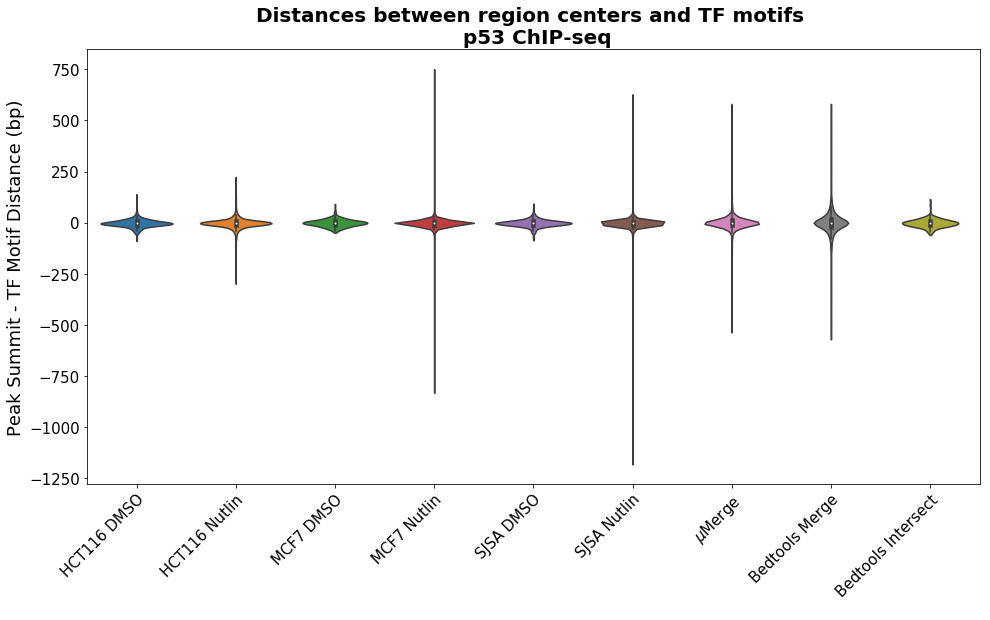

In [16]:
total_distances = sample_distances + merge_distances

total_ids = ['HCT116 DMSO','HCT116 Nutlin',
             'MCF7 DMSO','MCF7 Nutlin',
             'SJSA DMSO', 'SJSA Nutlin',
             r'$\mu$Merge', 
            'Bedtools Merge',
            'Bedtools Intersect']

fig, ax00 = plt.subplots(figsize=(16, 8))

ax00 = sns.violinplot(data=total_distances, cut=0, inner='box')
ax00.set_xticklabels(total_ids, rotation=45, ha="right",
         rotation_mode="anchor")

ax00.set_title('Distances between region centers and TF motifs \n p53 ChIP-seq',
             fontsize=20, fontweight='bold')
ax00.set_xlabel(' ')
ax00.set_ylabel('Peak Summit - TF Motif Distance (bp)',fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

fig.savefig("./figures/pdf/p53_RegionCenter_Motif_distances.pdf", bbox_inches='tight')
fig.savefig("./figures/png/p53_RegionCenter_Motif_distances.png", bbox_inches='tight')
fig.savefig("./figures/svg/p53_RegionCenter_Motif_distances.svg", bbox_inches='tight')

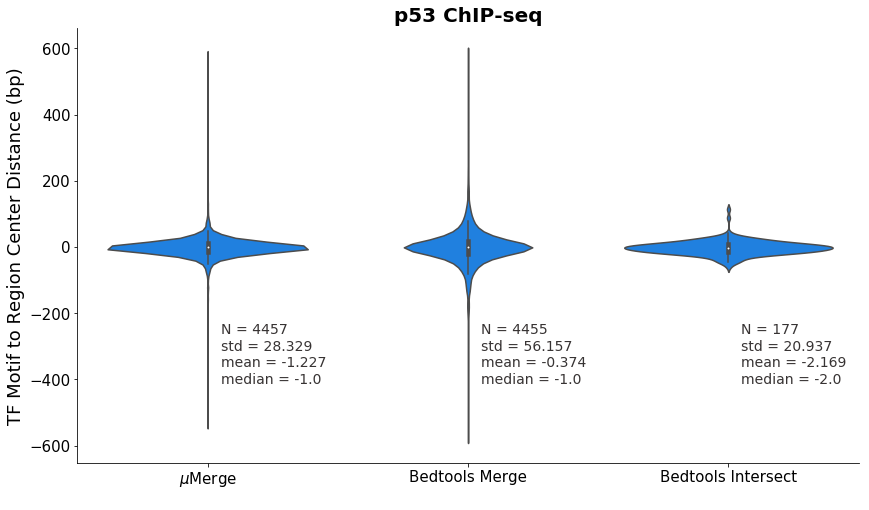

In [17]:
fig, ax01 = plt.subplots(figsize=(14, 8))

variance = []

for v in total_distances:
    var = np.var(v)
    variance.append(var)

ax01 = sns.violinplot(data=total_distances[6:], inner='box',color='#0080FF')#  #1c9099
ax01.set_xticklabels(total_ids[6:])

#Distances between region centers and TF motifs \n 

ax01.set_title('p53 ChIP-seq',
             fontsize=20, fontweight='bold')
ax01.set_xlabel(' ') 
ax01.set_ylabel('TF Motif to Region Center Distance (bp)',fontsize=18)#Distance Between Motif and Region Center

ax01.spines['right'].set_visible(False)
ax01.spines['top'].set_visible(False)
plt.legend(prop={'size': 12}, title = '')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

for i, j, k in zip([0.05,1.05,2.05], variance[6:], [6,7,8]):
    text = ax01.text(i, -250, 'N = ' + str(len(total_distances[k])),
                        ha="left", va="center", color="#373333",
                        fontsize=14)
    text = ax01.text(i, -300, 'std = ' + str(round(np.std(total_distances[k]),3)),
                       ha="left", va="center", color="#373333",
                       fontsize=14)
    text = ax01.text(i, -350, 'mean = ' + str(round(np.mean(total_distances[k]),3)),
                       ha="left", va="center", color="#373333",
                       fontsize=14)
    text = ax01.text(i, -400, 'median = ' + str(round(np.median(total_distances[k]),3)),
                       ha="left", va="center", color="#373333",
                       fontsize=14)
    
fig.savefig("./figures/pdf/p53_merged_RegionCenter_Motif_distances_violin.pdf", bbox_inches='tight')
fig.savefig("./figures/png/p53_merged_RegionCenter_Motif_distances_violin.png", bbox_inches='tight')
fig.savefig("./figures/svg/p53_merged_RegionCenter_Motif_distances_violin.svg", bbox_inches='tight')

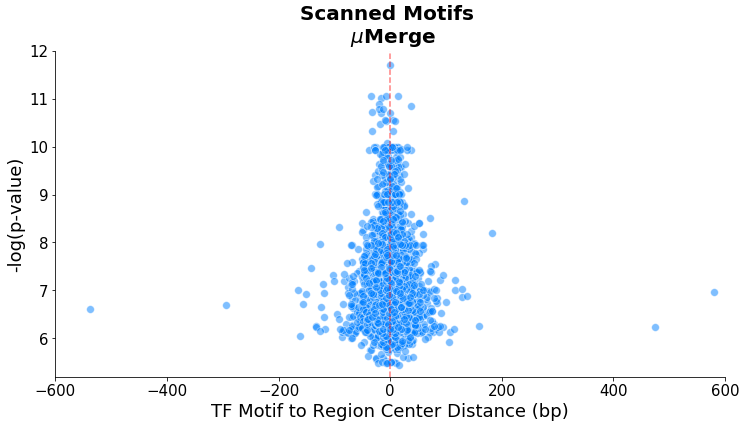

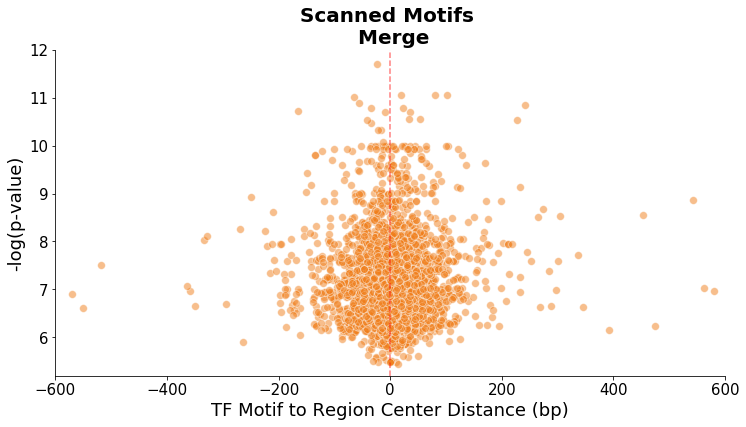

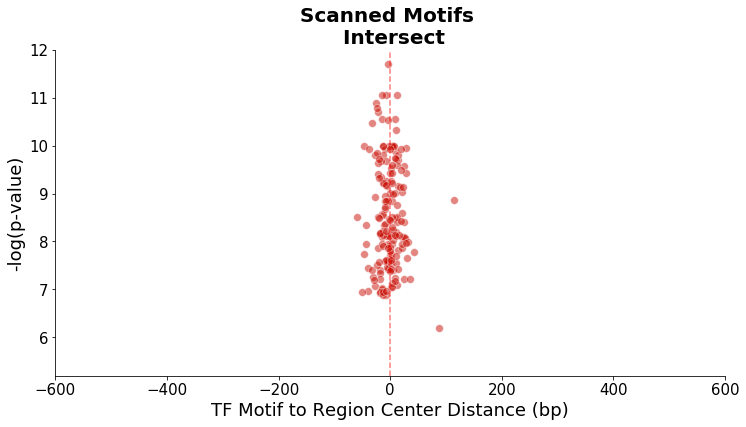

In [18]:
merge_samples_ids = [r'$\mu$Merge', 'Merge', 'Intersect']
cols = ['#0080FF', '#f07e1a', '#c90c02']

for dist, sig, label, col in zip(merge_distances, merge_motif_pval, merge_samples_ids, cols):
  
    fig, ax02 = plt.subplots(figsize=(12, 6))

    ax02 = sns.scatterplot(x=dist, y=-np.log10(sig), s=60,color=col, alpha=0.5)
    ax02.axvline(0, ls='--', color='red', linewidth=1.5, alpha=0.5)
    ax02.set_title('Scanned Motifs \n {}'.format(label),
                 fontsize=20, fontweight='bold')
    ax02.set_xlabel('TF Motif to Region Center Distance (bp)',fontsize=18)
    ax02.set_ylabel('-log(p-value)',fontsize=18)
    ax02.spines['right'].set_visible(False)
    ax02.spines['top'].set_visible(False)
    plt.legend(prop={'size': 12}, title = '')
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    ax02.set(xlim=(-600, 600))
    ax02.set(ylim=(5.2, 12.0))
    
    fig.savefig("./figures/pdf/p53_merged_RegionCenter_Motif_distances_{}.pdf".format(label), bbox_inches='tight')
    fig.savefig("./figures/png/p53_merged_RegionCenter_Motif_distances_{}.png".format(label), bbox_inches='tight')
    fig.savefig("./figures/svg/p53_merged_RegionCenter_Motif_distances_{}.svg".format(label), bbox_inches='tight')

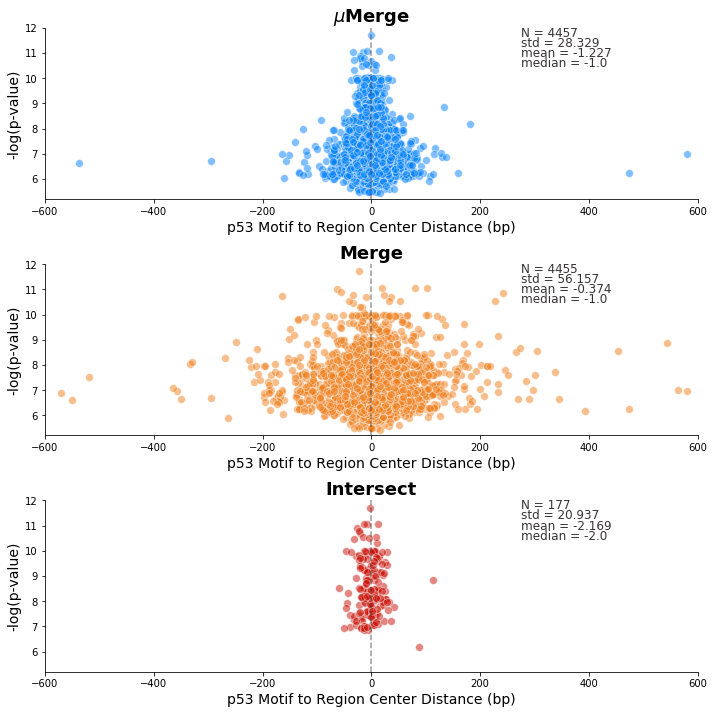

In [19]:
fig, ax03 = plt.subplots(nrows=3,figsize=(10, 10))

merge_samples_ids = [r'$\mu$Merge', 'Merge', 'Intersect']
cols = ['#0080FF', '#f07e1a', '#c90c02']

for dist, sig, label, i, col in zip(merge_distances, merge_motif_pval, merge_samples_ids, [0,1,2], cols):

        ax03[i] = sns.scatterplot(x=dist, y=-np.log10(sig), s=60,color=col, alpha=0.5,ax=ax03[i])
        ax03[i].axvline(0, ls='--', color="#373333", linewidth=1.5, alpha=0.5)
        ax03[i].set_title(label, fontsize=18, fontweight='bold')
        ax03[i].set_xlabel('p53 Motif to Region Center Distance (bp)',fontsize=14)
        ax03[i].set_ylabel('-log(p-value)',fontsize=14)
        ax03[i].spines['right'].set_visible(False)
        ax03[i].spines['top'].set_visible(False)
        ax03[i].set(xlim=(-600, 600))
        ax03[i].set(ylim=(5.2, 12.0))
        
        ax03[i].text(275, 11.8, 'N = ' + str(len(dist)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)
        ax03[i].text(275, 11.4, 'std = ' + str(round(np.std(dist),3)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)
        ax03[i].text(275, 11.0, 'mean = ' + str(round(np.mean(dist),3)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)
        ax03[i].text(275, 10.6, 'median = ' + str(round(np.median(dist),3)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)

        plt.tight_layout(pad=1.0)

fig.savefig("./figures/pdf/p53_merged_RegionCenter_Motif_distances.pdf", bbox_inches='tight')
fig.savefig("./figures/png/p53_merged_RegionCenter_Motif_distances.png", bbox_inches='tight')
fig.savefig("./figures/svg/p53_merged_RegionCenter_Motif_distances.svg", bbox_inches='tight')

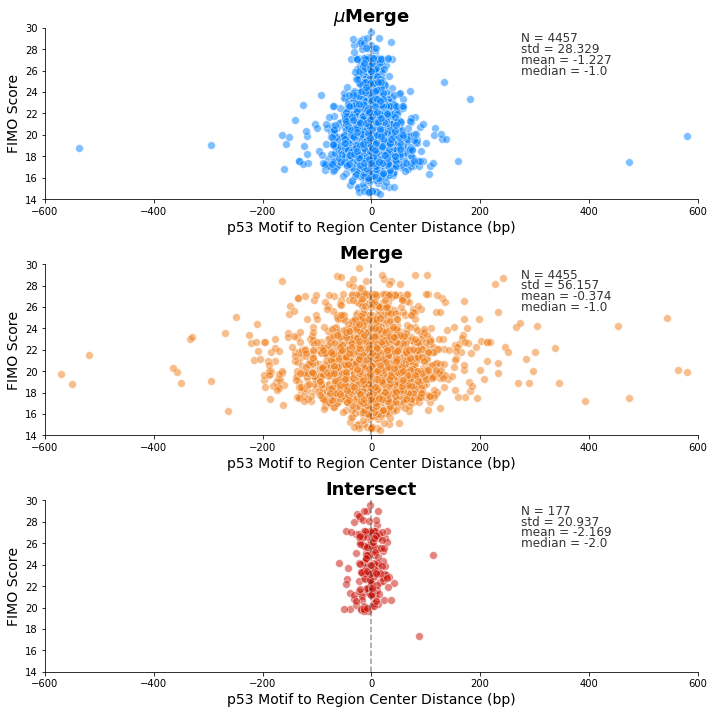

In [20]:
fig, ax04 = plt.subplots(nrows=3,figsize=(10, 10))

for dist, score, label, i, k, col in zip(merge_distances, merge_motif_score, merge_samples_ids, [0,1,2], [6,7,8], cols):

        ax04[i] = sns.scatterplot(x=dist, y=score, s=60,color=col, alpha=0.5,ax=ax04[i])
        ax04[i].axvline(0, ls='--', color="#373333", linewidth=1.5, alpha=0.5)
        ax04[i].set_title(label, fontsize=18, fontweight='bold')
        ax04[i].set_xlabel('p53 Motif to Region Center Distance (bp)',fontsize=14)
        ax04[i].set_ylabel('FIMO Score',fontsize=14)
        ax04[i].spines['right'].set_visible(False)
        ax04[i].spines['top'].set_visible(False)
        ax04[i].set(xlim=(-600, 600))
        ax04[i].set(ylim=(14, 30.0))
        
        ax04[i].text(275, 29, 'N = ' + str(len(dist)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)
        ax04[i].text(275, 28, 'std = ' + str(round(np.std(dist),3)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)
        ax04[i].text(275, 27, 'mean = ' + str(round(np.mean(dist),3)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)
        ax04[i].text(275, 26, 'median = ' + str(round(np.median(dist),3)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)

        plt.tight_layout(pad=1.0)

fig.savefig("./figures/pdf/p53_merged_RegionCenter_Motif_distances_score.pdf", bbox_inches='tight')
fig.savefig("./figures/png/p53_merged_RegionCenter_Motif_distances_score.png", bbox_inches='tight')
fig.savefig("./figures/svg/p53_merged_RegionCenter_Motif_distances_score.svg", bbox_inches='tight')

## 3kb window

In [12]:
merge_samples = ['Andrysik2017_mumerged.bed_MUMERGE.bed',
                 'Andrysik2017_merged.bed',
                 'Andrysik2017_intersect_recursive.bed']

summary_narrow3kb = '/scratch/Users/rusi2317/projects/mumerge_test_p53/processed_data/merged_regions3kb/' 
summary_fimo3kb = '/scratch/Users/rusi2317/projects/mumerge_test_p53/processed_data/fimo_scans_merged3kb/' 

merge_distances3kb = []
merge_motif_sig3kb = []
merge_motif_score3kb = []
merge_motif_pval3kb = []

for sample_name in merge_samples:
    print('---------------------------------------------------------------------')
    print(".......Assessing......." + sample_name)
    
    #load files
    merged_narrow = merged_center(summary_narrow3kb + sample_name) 
    merged_summit = merged_center_bed(merged_narrow)
    merged_fimo = load_fimo(summary_fimo3kb + sample_name + '/fimo.tsv')
    
    #filter regions
    fimo_filtered = filter_fimo(merged_fimo, alpha=9e-01)
    
    fimo_filtered_unique = unique_sig_fimo_hits(fimo_filtered)
    
    #calculate distances between peaks and TF motif
    motif_peak_dist, motif_sig, motif_score, pval = summit_motif_dist(merged_narrow,
                                                                merged_summit,
                                                                fimo_filtered_unique)
    
    merge_distances3kb.append(motif_peak_dist)
    merge_motif_sig3kb.append(motif_sig)
    merge_motif_score3kb.append(motif_score)
    merge_motif_pval3kb.append(pval)
    
    print('.....DONE processing.....' + sample_name)
    print('---------------------------------------------------------------------')
    print(' ')
    

---------------------------------------------------------------------
.......Assessing.......Andrysik2017_mumerged.bed_MUMERGE.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 15254
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.9 ----------
Sequences with motif hits => 4455
.....DONE processing.....Andrysik2017_mumerged.bed_MUMERGE.bed
---------------------------------------------------------------------
 
---------------------------------------------------------------------
.......Assessing.......Andrysik2017_merged.bed
---------------------------------------------------------------------
--------------------- STORING FIMO RESULTS FILE ---------------------
-> Number of Fimo Calls = 15267
--------- FILTERING MOTIF HITS AT AN ALPHA LEVEL OF 0.9 ----------
Sequences with motif hits => 4453
.....DONE processing.....Andrysik2017_merged.bed
----------------------

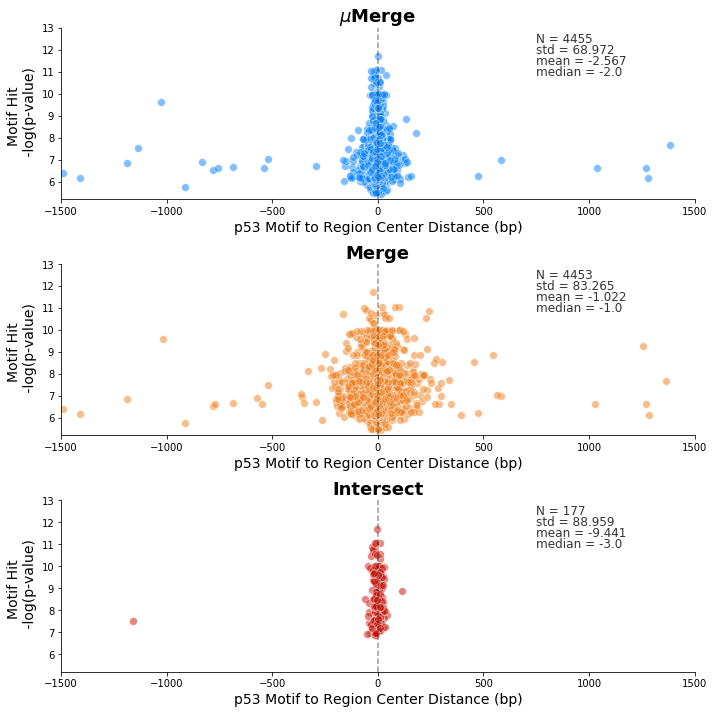

In [21]:
fig, ax03 = plt.subplots(nrows=3,figsize=(10, 10))

merge_samples_ids = [r'$\mu$Merge', 'Merge', 'Intersect']
cols = ['#0080FF', '#f07e1a', '#c90c02']

for dist, sig, label, i, k, col in zip(merge_distances3kb, merge_motif_pval3kb, 
                                       merge_samples_ids, [0,1,2], [6,7,8], cols):

        ax03[i] = sns.scatterplot(x=dist, y=-np.log10(sig), s=60,color=col, alpha=0.5,ax=ax03[i])
        ax03[i].axvline(0, ls='--', color="#373333", linewidth=1.5, alpha=0.5)
        ax03[i].set_title(label, fontsize=18, fontweight='bold')
        ax03[i].set_xlabel('p53 Motif to Region Center Distance (bp)',fontsize=14)
        ax03[i].set_ylabel('Motif Hit \n -log(p-value)',fontsize=14)
        ax03[i].spines['right'].set_visible(False)
        ax03[i].spines['top'].set_visible(False)
        ax03[i].set(xlim=(-1500, 1500))
        ax03[i].set(ylim=(5.2, 13.0))
        
        ax03[i].text(750, 12.5, 'N = ' + str(len(dist)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)
        ax03[i].text(750, 12.0, 'std = ' + str(round(np.std(dist),3)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)
        ax03[i].text(750, 11.5, 'mean = ' + str(round(np.mean(dist),3)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)
        ax03[i].text(750, 11.0, 'median = ' + str(round(np.median(dist),3)),
                     ha="left", va="center", color="#373333",
                     fontsize=12)

        plt.tight_layout(pad=1.0)

fig.savefig("./figures/pdf/p53_merged_RegionCenter_Motif_distances3kb.pdf", bbox_inches='tight')
fig.savefig("./figures/svg/p53_merged_RegionCenter_Motif_distances3kb.svg", bbox_inches='tight')
fig.savefig("./figures/png/p53_merged_RegionCenter_Motif_distances3kb.png", bbox_inches='tight')